### Project Setup and File Conversions

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import random
from fpdf import FPDF
import plotly as pl
import plotly.graph_objects as go
import plotly.io as pio
import folium
from folium.plugins import HeatMap
from sklearn.linear_model import LinearRegression
import swifter

# Analysis of Inflow and Outflow of Immigrants Across EU

### Data Source Preprocessing

#### Defining Countries of Interest
We will only include countries that are part of both EU and Schengen. 

In [2]:

schengen_countries = [
    'Austria', 'Belgium', 'Croatia', 'Czechia', 'Denmark', 'Estonia',
    'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
    'Malta', 'Netherlands', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain','Sweden']


#### Define Function to clean data
To clean and be able to process the data easier, we defined a function that will perform the following actions:
- Remove the irrelevant columns and header rows.
- Set the column names to the years and row index to the countries.
- Replace the string representing missing values to a type that is more easily handled by pandas.
- Filter to only the countries of interest.

In [3]:

def clean_data(data):
    # Removes unnecessary rows and columns
    data.drop(data.columns[1], axis=1, inplace=True)
    data.drop(data.index[[-1, 1]], inplace=True)

    # Extracts years from year row
    years = data.iloc[0].dropna().values[1:].astype(int)
    data.drop(data.index[0], inplace=True)

    # Removes columns without data
    data.dropna(axis=1, how='all', inplace=True)

    # Assign years as names to columns
    data.rename(columns=dict(zip(data.columns[1:], years)), inplace=True)
    data.rename(columns={data.columns[0]: 'Country'}, inplace=True)

    # Set the index to countries
    data.set_index('Country', inplace=True)

    # Change missing values to NaN 
    data.replace('..', np.nan, inplace=True)

    # Filtering data on only schengen countries
    data.rename(index={'Slovak Republic': 'Slovakia'}, inplace=True)
    data.query('index in @schengen_countries', inplace=True)

    return data

#### Define Function to aggregate data
The function below creates columns for total and average on the dataframe.

In [4]:
def aggregate_data(data):
    data['Total'] = data.sum(axis=1)
    data['Average'] = data.mean(axis=1)
    return data

### Apply Clean and Aggregate functions to each dataset

#### Inflow of foreign population
**Inflow Population** in the dataset refers to the number of people moving to a country at a certain year.

In [5]:
file = 'Inflows of foreign population by nationality.xls'
foreign_population_inflow_df = pd.read_excel(f'data/converted/{file}', skiprows = 4)
clean_data(foreign_population_inflow_df)
aggregate_data(foreign_population_inflow_df)
foreign_population_inflow_df.head(5)

2000     2001     2002     2003      2004     2005     2006  \
Country                                                                   
Austria  65954.0  74786.0  86144.0  93341.0  104246.0  97995.0  82899.0   
Belgium  57295.0  65974.0  70230.0  68800.0   72446.0  77411.0  83433.0   
Czechia   4227.0  11323.0  43648.0  57438.0   50804.0  58576.0  66125.0   
Denmark  22766.0  24642.0  21485.0  18385.0   18706.0  20146.0  23979.0   
Estonia      NaN      NaN      NaN      NaN     759.0    981.0   1488.0   

             2007      2008      2009  ...      2015      2016      2017  \
Country                                ...                                 
Austria   91546.0   94368.0   91660.0  ...  198658.0  158746.0  139329.0   
Belgium   93387.0  106012.0  102714.0  ...  128762.0  106087.0  109167.0   
Czechia  102511.0   76151.0   38199.0  ...   31589.0   34808.0   43527.0   
Denmark   31430.0   37018.0   31957.0  ...   58695.0   54641.0   49041.0   
Estonia    1952.0    1929.0    2229.0  ...    7370.0    7693.0    9067.0   

             2018      2019      2020      2021  2022      Total  \
Country                                                            
Austria  131724.0  134966.0  121311.0  139543.0   NaN  2529126.0   
Belgium  119663.0  129450.0  101553.0  122386.0   NaN  2193010.0   
Czechia   55872.0   63340.0   53795.0   67270.0   NaN  1002862.0   
Denmark   45259.0   42268.0   37810.0   47274.0   NaN   779387.0   
Estonia    9711.0   10953.0   10309.0   12468.0   NaN    83870.0   

               Average  
Country                 
Austria  219924.000000  
Belgium  190696.521739  
Czechia   87205.391304  
Denmark   67772.782609  
Estonia    8828.421053  

[5 rows x 25 columns]

#### Outflow of Foreign Population
**Outflow Population** in the dataset refers to the number of people moving out of a country at a certain year.

In [6]:
file = 'Outflows of foreign population by nationality.xls'
foreign_population_outflow_df = pd.read_excel(f'data/converted/{file}', skiprows=4)

clean_data(foreign_population_outflow_df)
aggregate_data(foreign_population_outflow_df)
foreign_population_outflow_df.head(5)

2000     2001     2002     2003     2004     2005     2006  \
Country                                                                  
Austria  44350.0  51004.0  44478.0  48940.0  50018.0  49800.0  55045.0   
Belgium  35568.0  31391.0  31046.0  33921.0  37728.0  38459.0  39354.0   
Czechia    161.0  20566.0  31091.0  33203.0  33784.0  21796.0  31388.0   
Denmark  13988.0  14798.0  14887.0  15757.0  15761.0  16295.0  17269.0   
Estonia      NaN      NaN      NaN      NaN    648.0    646.0    563.0   

            2007     2008     2009  ...     2015     2016     2017     2018  \
Country                             ...                                       
Austria  56643.0  60226.0  67219.0  ...  80141.0  89026.0  89556.0  91707.0   
Belgium  38511.0  44937.0  49126.0  ...  59845.0  61780.0  58582.0  56790.0   
Czechia  18424.0   3821.0   9350.0  ...  15024.0  13441.0  14428.0  16248.0   
Denmark  18995.0  23341.0  26596.0  ...  30605.0  37378.0  41531.0  45435.0   
Estonia    444.0    546.0    686.0  ...   3290.0   3402.0   4344.0   3907.0   

            2019     2020     2021  2022      Total        Average  
Country                                                             
Austria  90010.0  79410.0  84574.0   NaN  1498776.0  130328.347826  
Belgium  46533.0  52027.0  59051.0   NaN  1065764.0   92675.130435  
Czechia  17476.0  26766.0  18220.0   NaN   400016.0   34784.000000  
Denmark  52364.0  41743.0  31493.0   NaN   601157.0   52274.521739  
Estonia   6221.0   5507.0   5531.0   NaN    37970.0    3996.842105  

[5 rows x 25 columns]

#### Stock of Foreign Population
**Foreign Population** refers to individuals living on a certain country who are not citizens or nationals of the country. This could refer to people who are born outside the country but are living under immigrant or refugee status.

In [7]:
file = 'Stock of foreign population by nationality.xls'
stock_population_foreign_df = pd.read_excel(f'data/converted/{file}', skiprows=4)

clean_data(stock_population_foreign_df)
aggregate_data(stock_population_foreign_df)
stock_population_foreign_df.head(5)

2000      2001      2002      2003      2004      2005      2006  \
Country                                                                         
Austria  693955.0  701768.0  730261.0  746753.0  754216.0  774401.0  796666.0   
Belgium  897110.0  861685.0  846734.0  850077.0  860287.0  870862.0  900473.0   
Czechia  228862.0  200951.0  210794.0  231608.0  240421.0  254294.0  278312.0   
Denmark  259357.0  258629.0  266729.0  265424.0  271211.0  267604.0  270051.0   
Estonia  291724.0  287072.0  273766.0       NaN       NaN       NaN       NaN   

             2007      2008       2009  ...       2015       2016       2017  \
Country                                 ...                                    
Austria  804779.0  829679.0   860004.0  ...  1146078.0  1267674.0  1341930.0   
Belgium  932161.0  971448.0  1013260.0  ...  1276903.0  1333243.0  1353775.0   
Czechia  321456.0  392315.0   437565.0  ...   449367.0   464670.0   493441.0   
Denmark  278096.0  298490.0   320188.0  ...   422559.0   463147.0   484986.0   
Estonia       NaN       NaN        NaN  ...   211431.0   211517.0   212213.0   

              2018       2019       2020       2021       2022       Total  \
Country                                                                      
Austria  1395880.0  1438923.0  1486223.0  1531072.0  1586709.0  23705564.0   
Belgium  1376432.0  1413750.0  1478847.0  1489156.0  1514863.0  26146347.0   
Czechia   524142.0   564345.0   593366.0   632570.0   658564.0   9343088.0   
Denmark   505992.0   525898.0   537122.0   539494.0   562248.0   8604074.0   
Estonia   213667.0   216350.0   215611.0   201252.0   203383.0   3171737.0   

              Average  
Country                
Austria  1.975464e+06  
Belgium  2.178862e+06  
Czechia  7.785907e+05  
Denmark  7.170062e+05  
Estonia  4.228983e+05  

[5 rows x 25 columns]

#### Stock of Foreign-born Population

In [8]:
file = 'Stock of foreign-born population by country of birth.xls'
stock_population_foreign_born_df = pd.read_excel(f'data/converted/{file}', skiprows=4)

clean_data(stock_population_foreign_born_df)
aggregate_data(stock_population_foreign_born_df)
stock_population_foreign_born_df.head(5)

2000       2001       2002       2003       2004       2005  \
Country                                                                     
Austria   872000.0   843000.0  1112094.0  1137351.0  1141212.0  1154776.0   
Belgium  1064214.0  1080790.0  1117261.0  1156732.0  1185456.0  1220062.0   
Czechia        NaN   448477.0        NaN        NaN        NaN        NaN   
Denmark   296924.0   308674.0   321794.0   331506.0   337802.0   343367.0   
Estonia   257065.0   252686.0   249496.0        NaN        NaN        NaN   

              2006       2007       2008       2009  ...       2015  \
Country                                              ...              
Austria  1195156.0  1215695.0  1235678.0  1260277.0  ...  1484595.0   
Belgium  1268915.0  1319302.0  1380323.0  1443937.0  ...  1786080.0   
Czechia        NaN        NaN        NaN        NaN  ...   416454.0   
Denmark   350436.0   360902.0   378665.0   401771.0  ...   501057.0   
Estonia        NaN        NaN        NaN   221888.0  ...   194730.0   

              2016       2017       2018       2019       2020       2021  \
Country                                                                     
Austria  1594723.0  1656266.0  1697123.0  1728554.0  1765311.0  1797573.0   
Belgium  1849287.0  1880808.0  1920457.0  1973007.0  2056415.0  2079757.0   
Czechia   433290.0   465056.0   467580.0   507051.0   533639.0   570139.0   
Denmark   540503.0   570581.0   591678.0   607622.0   614353.0   617770.0   
Estonia   193859.0   192561.0   196289.0   198064.0   199042.0   198243.0   

              2022       Total       Average  
Country                                       
Austria  1842426.0  31406481.0  2.617207e+06  
Belgium  2125700.0  36197218.0  3.016435e+06  
Czechia   453424.0   6214639.0  8.878056e+05  
Denmark   640922.0  10333636.0  8.611363e+05  
Estonia   201253.0   3592565.0  3.991739e+05  

[5 rows x 25 columns]

### Data Cleaning

## Data Analysis and Visualization

### Part 1: Visualizing Migrant Populations for each EU country
In the first part of our data analysis and visualization. We create bar graphs to compare which countries have the highest migrant population for each category.

#### Define Function for creating bar charts
The function defined below accepts the population dataframe and its name. A bar chart will be created with x values corresponding to each countries and y values to total population count across all years. A color scale is introduced to better emphasize which country has the highest numbers.

In [9]:
def create_population_bar_chart(data, field_name ='Foreign Population'):
    sorted_df = data.sort_values(by='Total', ascending = False)
    #Creates a bar chart for population for each country
    bar_chart = go.Bar(
        x = sorted_df.index,
        y = sorted_df['Total'],
        name = f'{field_name}',
        marker = {'color': sorted_df['Total'], 'colorscale': 'Viridis'}
    )
    figure = go.Figure(data = [bar_chart])

    # Adds the necessary axis names
    figure.update_layout(
        title = f'{field_name} of Schengen Countries from 2000-2022',
        xaxis_title = 'Country',
        yaxis_title = field_name,
        height = 500
    )
    figure.show()

### Inflow Population

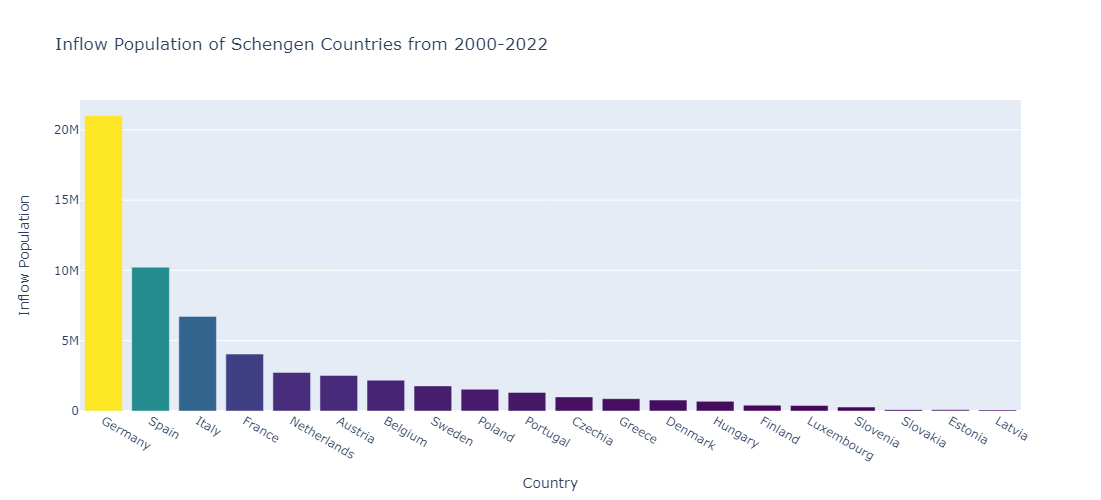

In [10]:
create_population_bar_chart(foreign_population_inflow_df, 'Inflow Population')

### Outflow Population

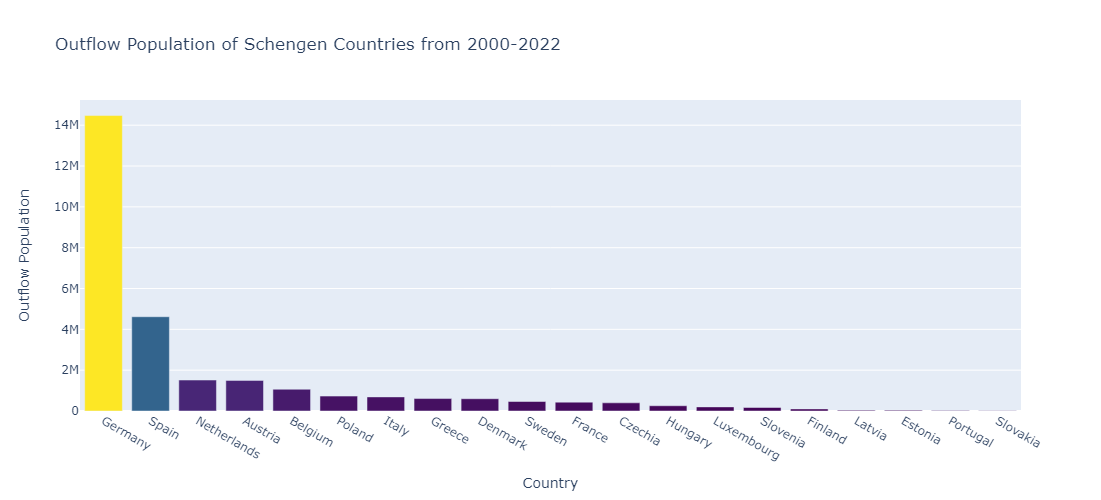

In [11]:
create_population_bar_chart(foreign_population_outflow_df, 'Outflow Population')

### Stock of Foreign Population

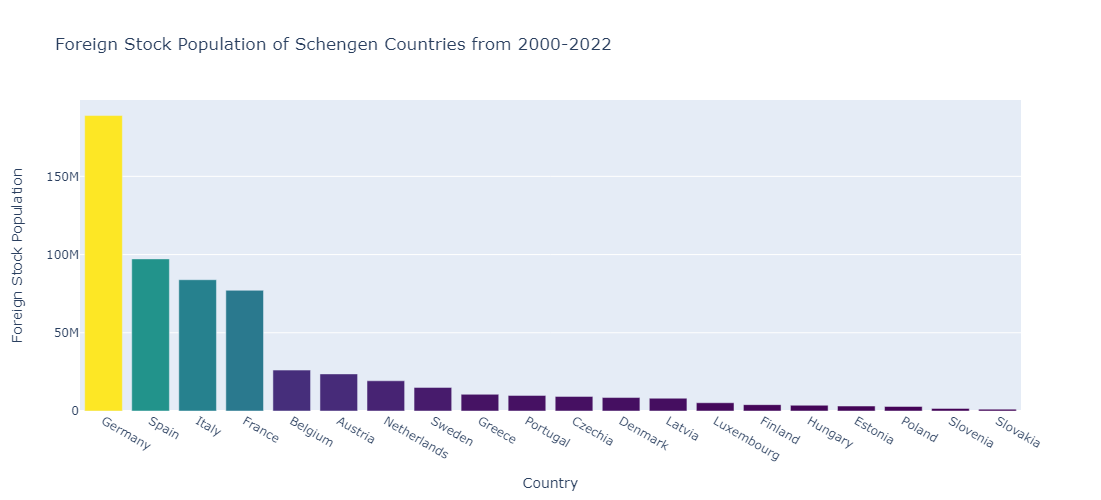

In [12]:
create_population_bar_chart(stock_population_foreign_df, 'Foreign Stock Population')

### Stock of Foreign Born Population

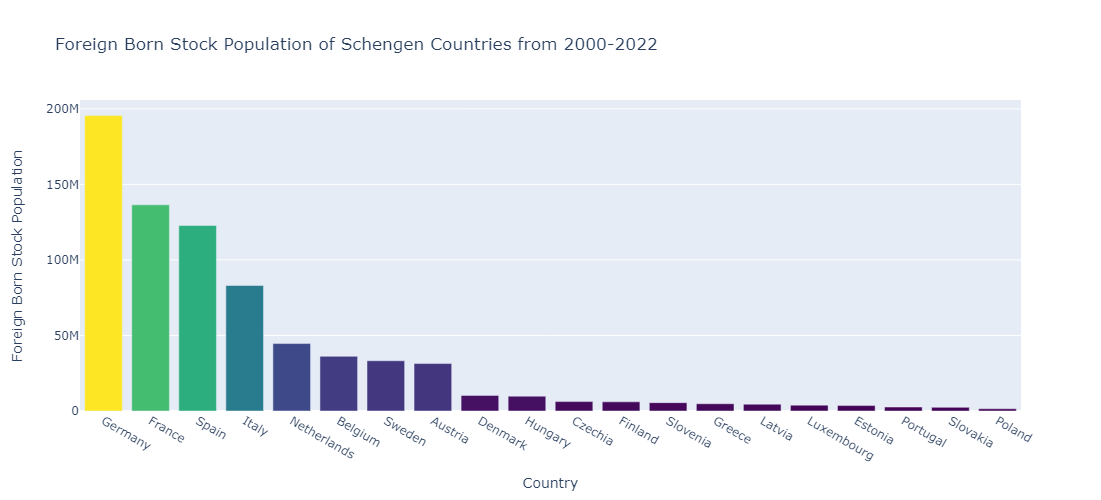

In [13]:
create_population_bar_chart(stock_population_foreign_born_df, 'Foreign Born Stock Population')

### Part 2: Time Series Analysis of Countries

#### Visualization of population change over time across each EU country

#### Total Inflow and Outflow 2000 - 2022

In [31]:
def create_time_series_plot(data):
    data.dropna(inplace = True)
    #Create a linear plot from dataframe
    plot = go.Scatter(
        x =data.index[:-2],
        y =data.values[:-2],
        mode='lines',  
    )

    #Adds necessary labels to plot
    layout = go.Layout(
        title=f'Time Series Analysis for {data.name}',  
        xaxis=dict(title='Year'), 
        yaxis=dict(title='Total Inflow Population'),  
        height = 300,
    )
    fig = go.Figure(data=[plot], layout=layout)
    fig.show()

### Inflow Population

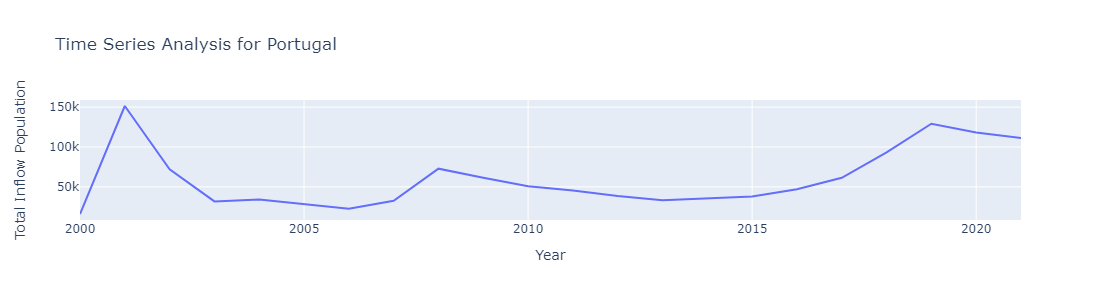

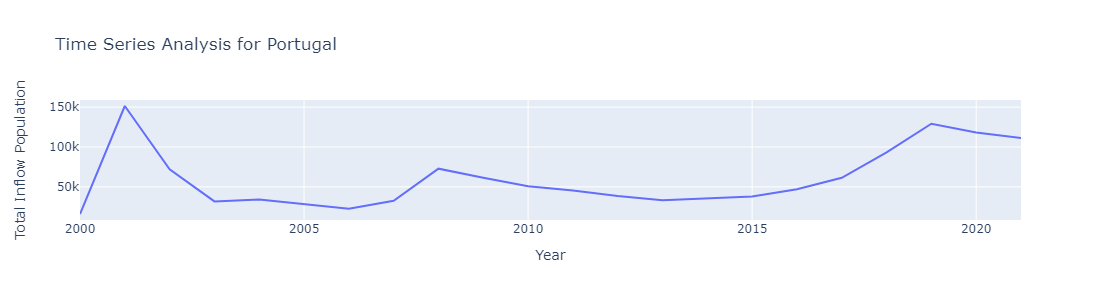

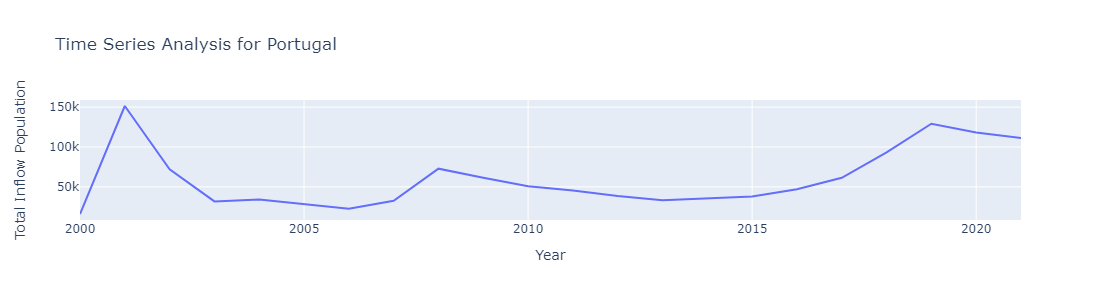

Pandas Apply:   0%|          | 0/20 [00:00<?, ?it/s]

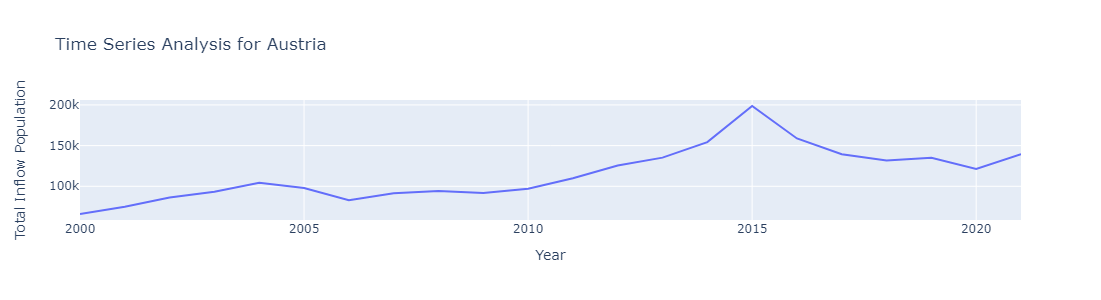

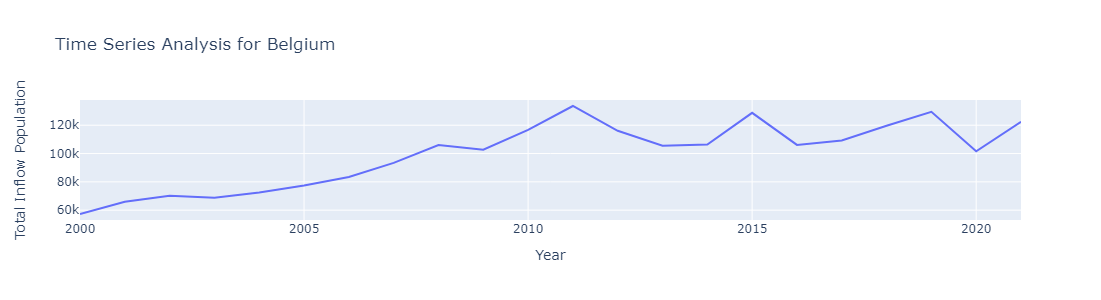

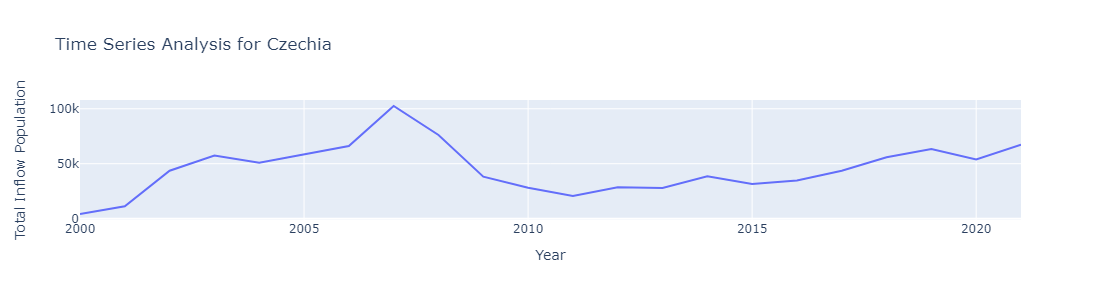

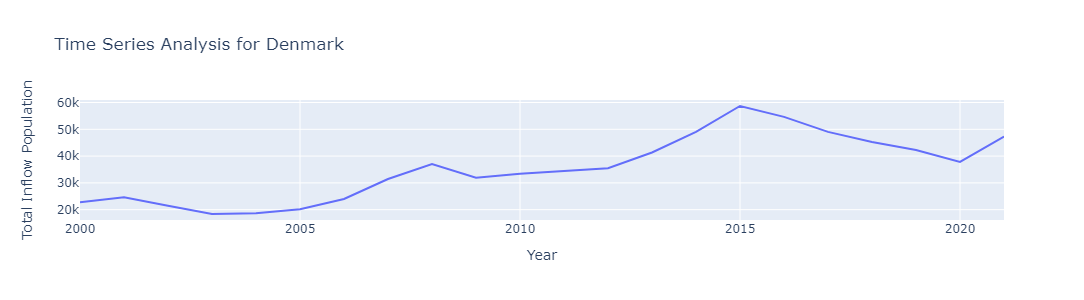

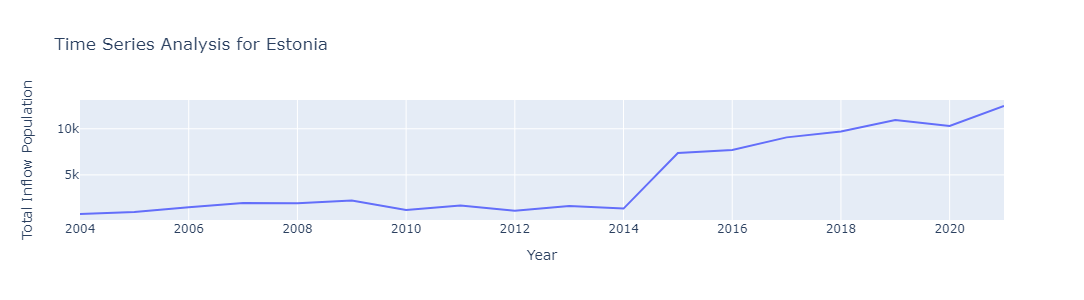

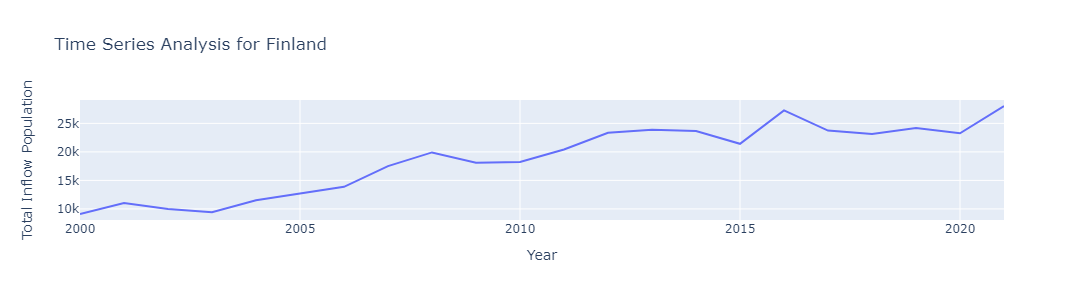

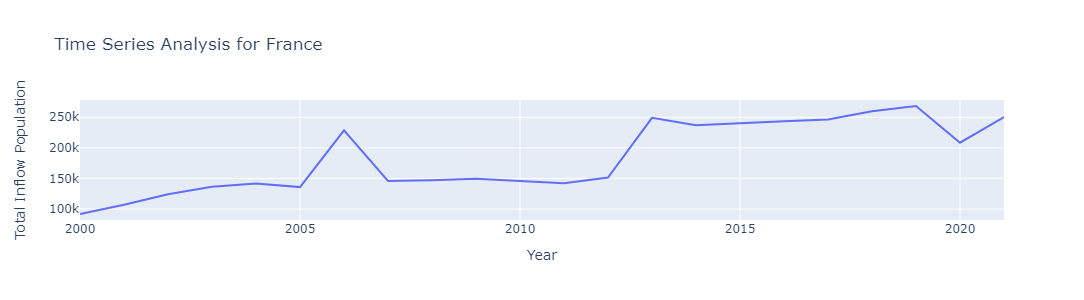

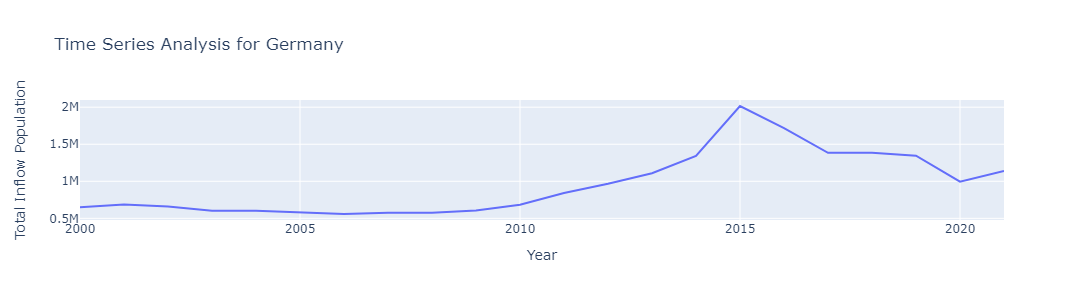

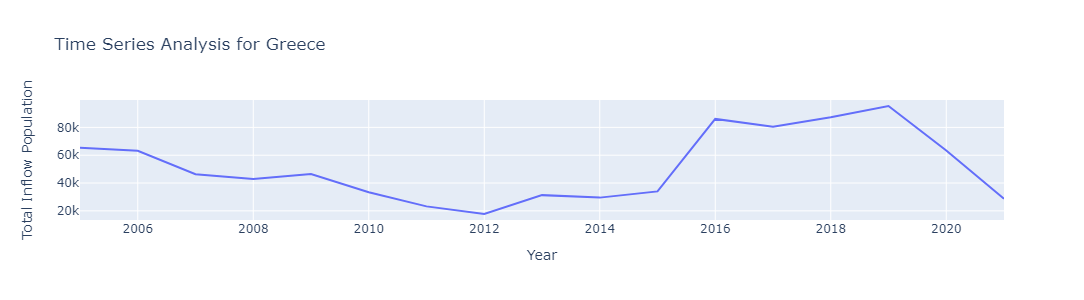

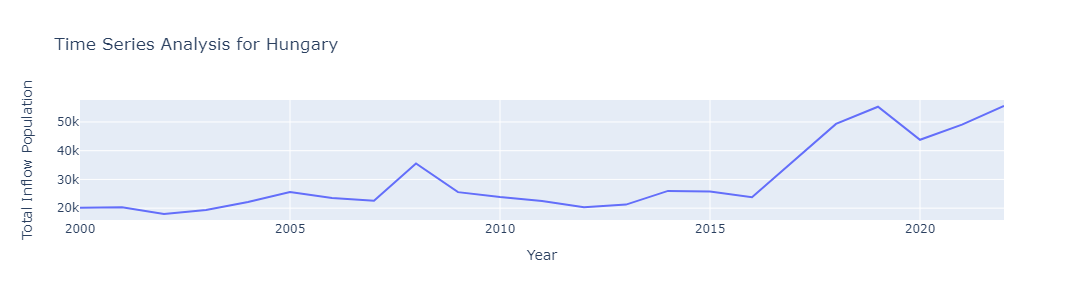

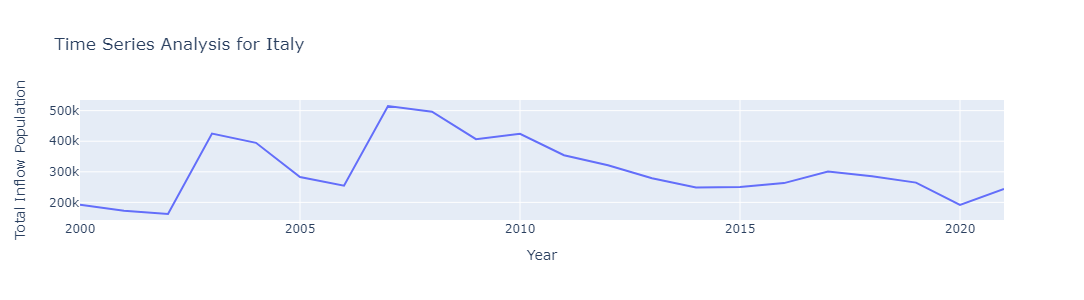

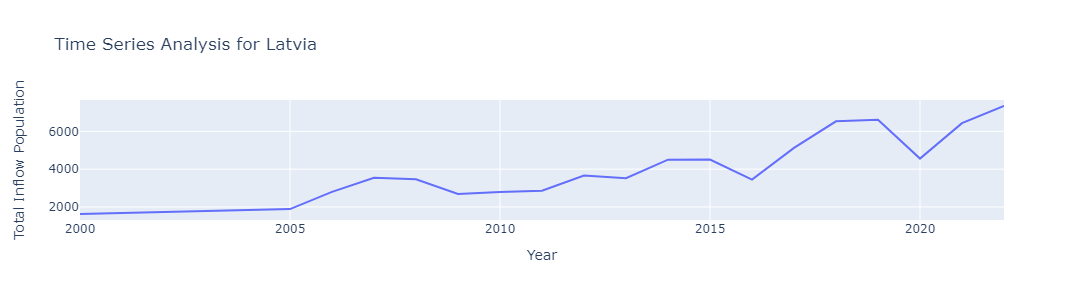

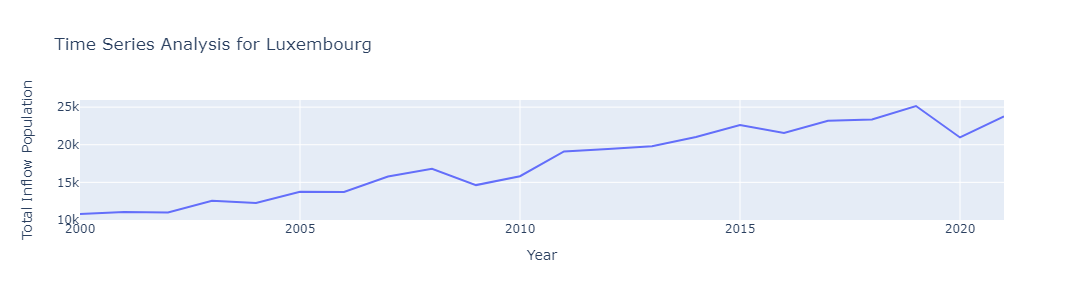

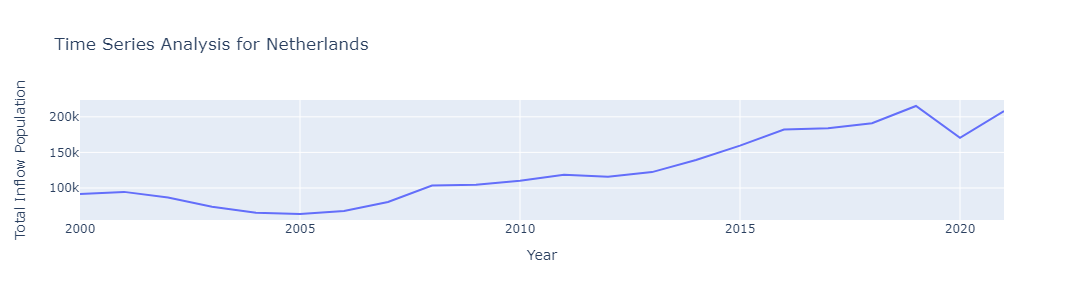

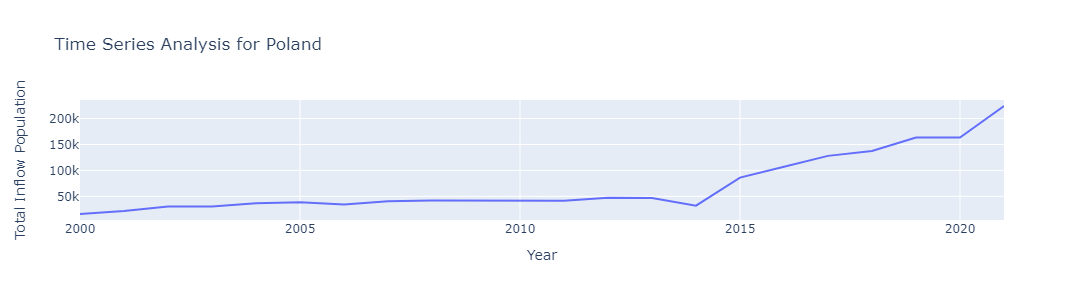

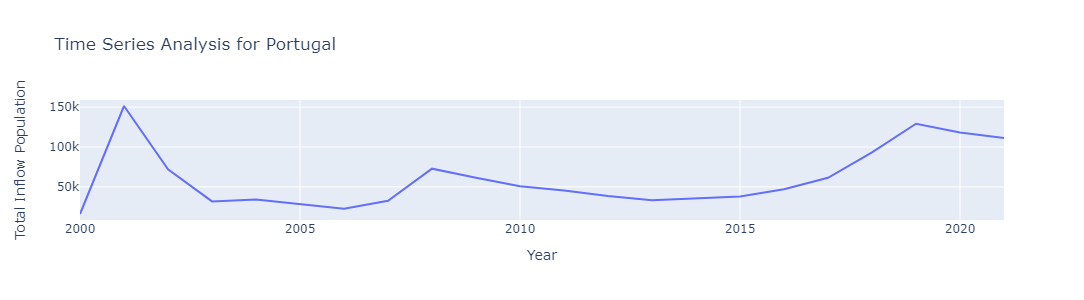

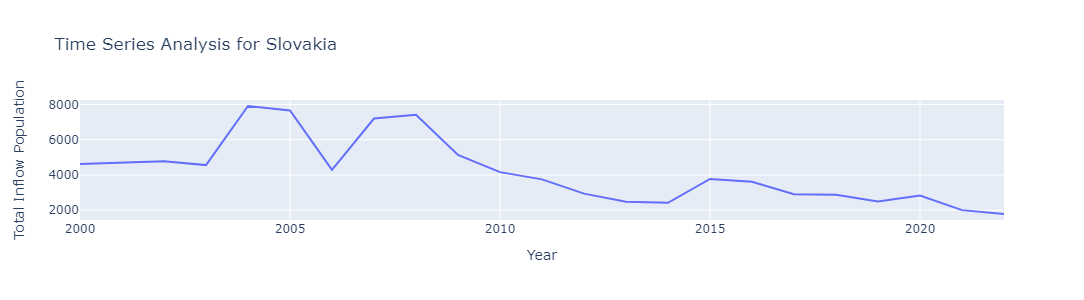

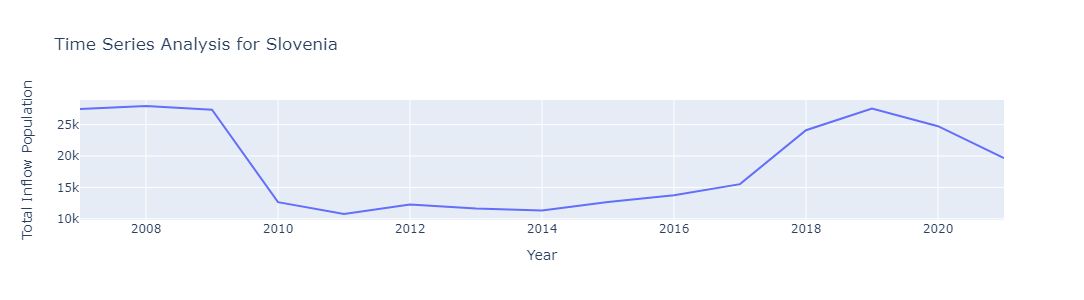

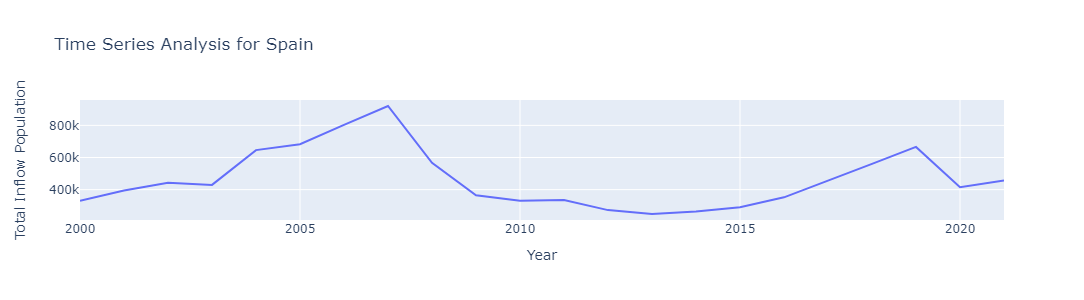

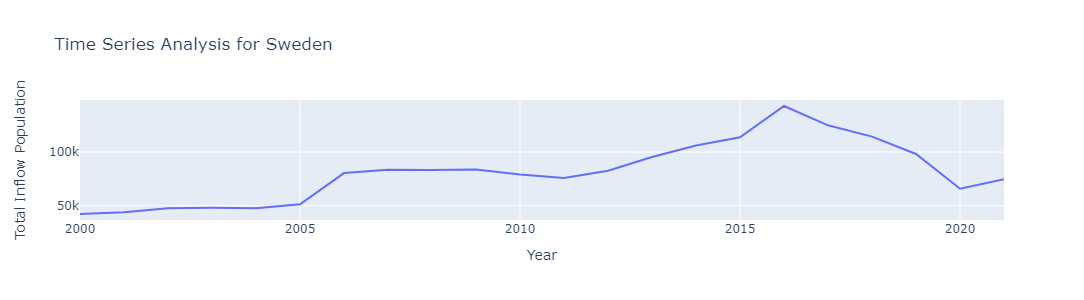

In [32]:
foreign_population_inflow_df.swifter.apply(create_time_series_plot, axis=1);

### Outflow Population

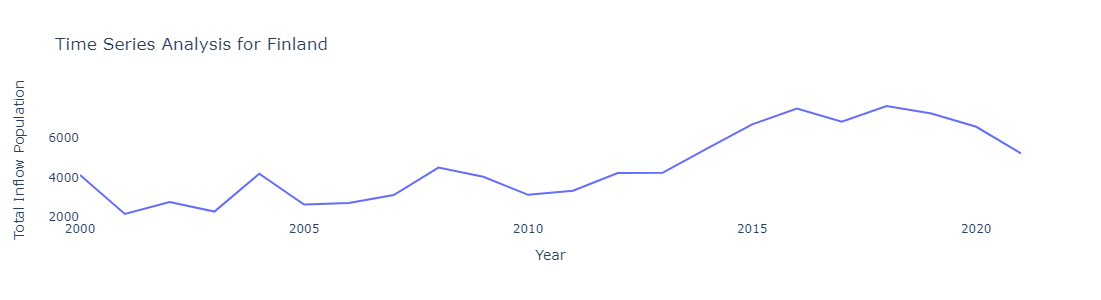

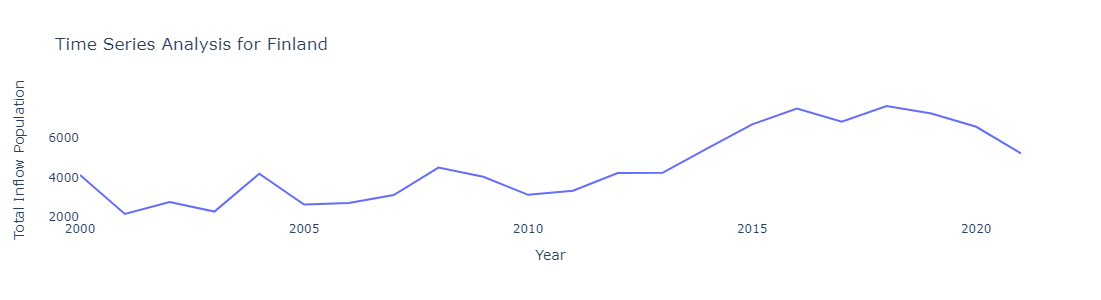

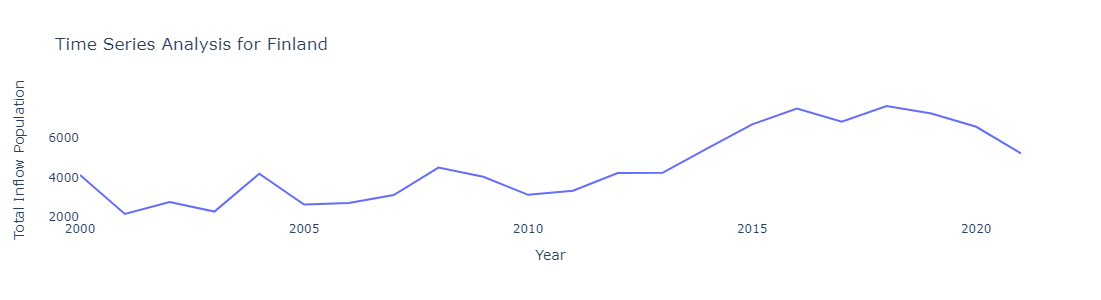

Pandas Apply:   0%|          | 0/20 [00:00<?, ?it/s]

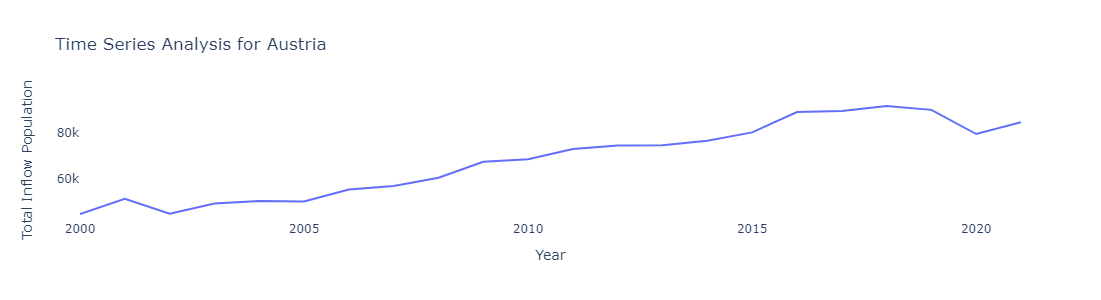

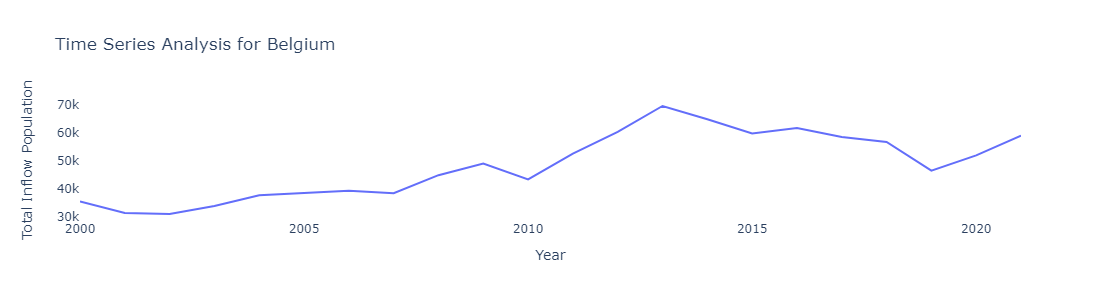

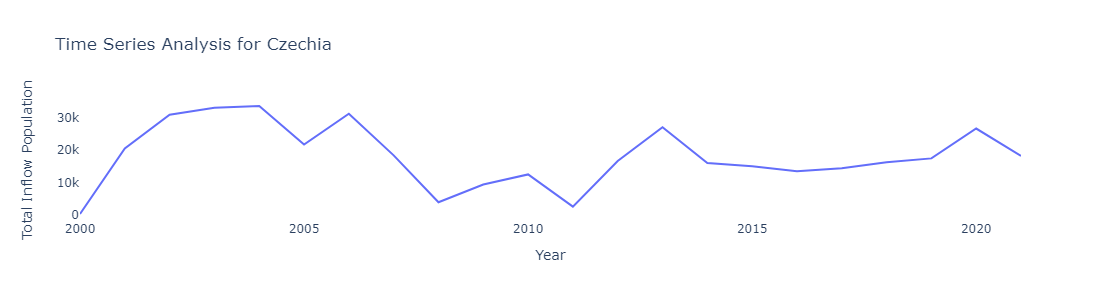

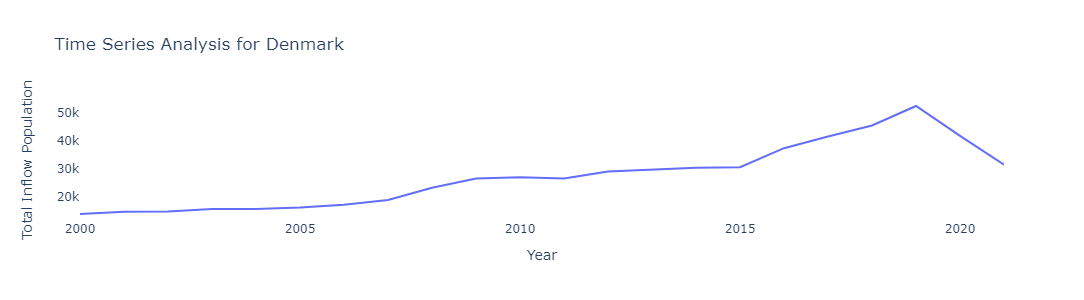

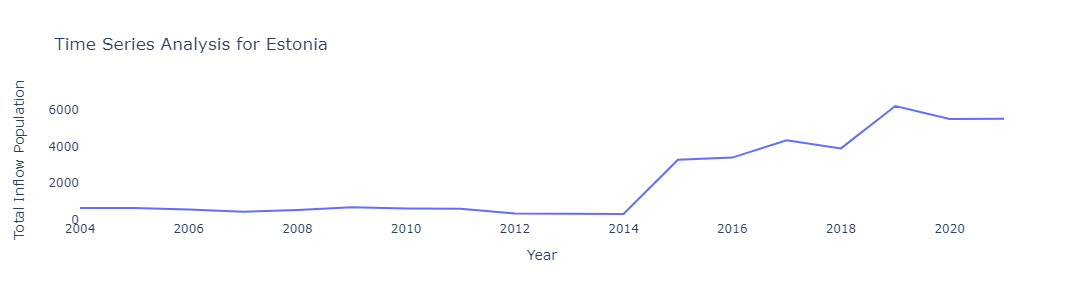

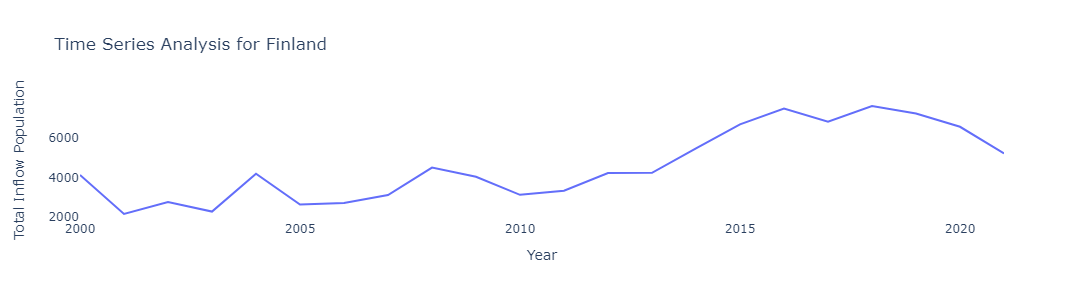

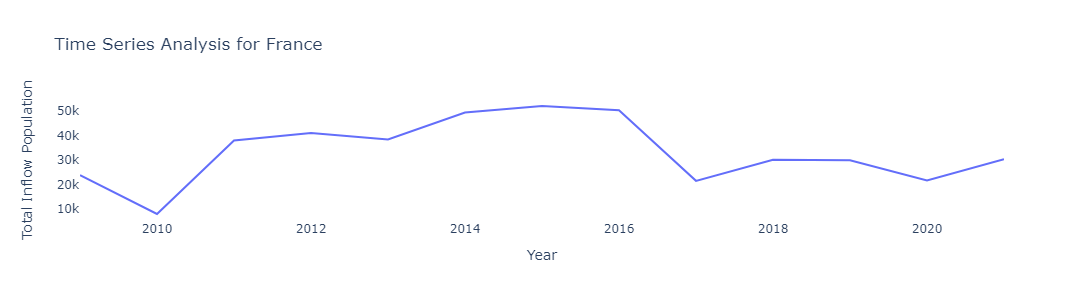

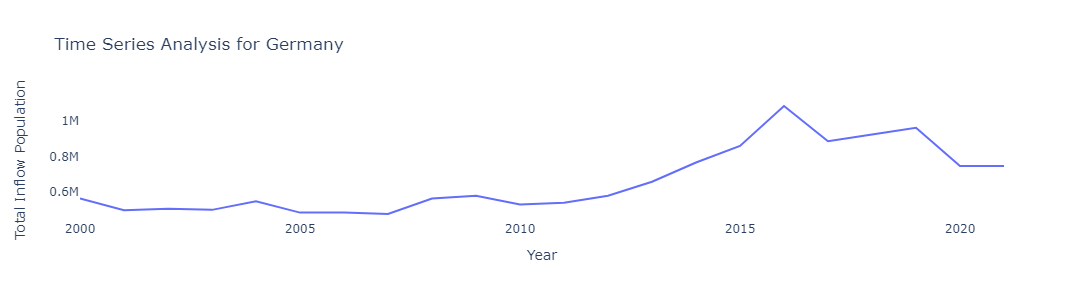

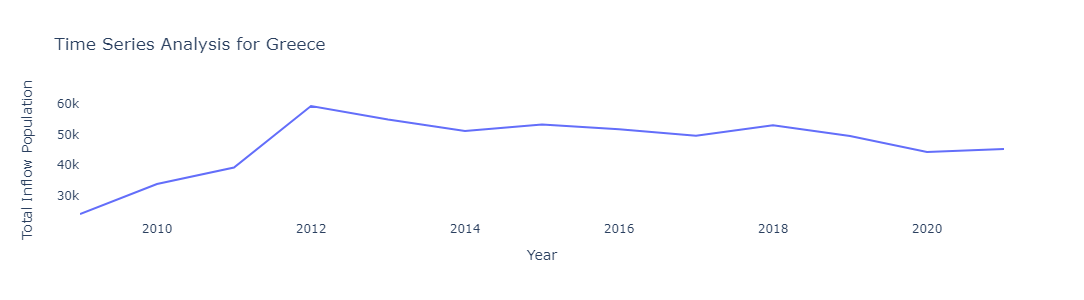

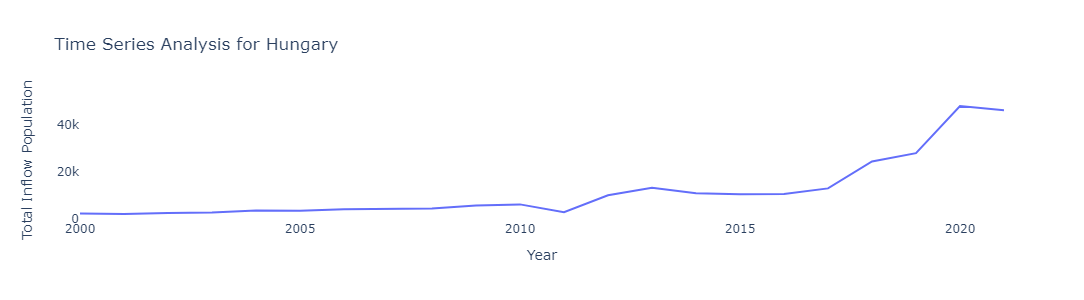

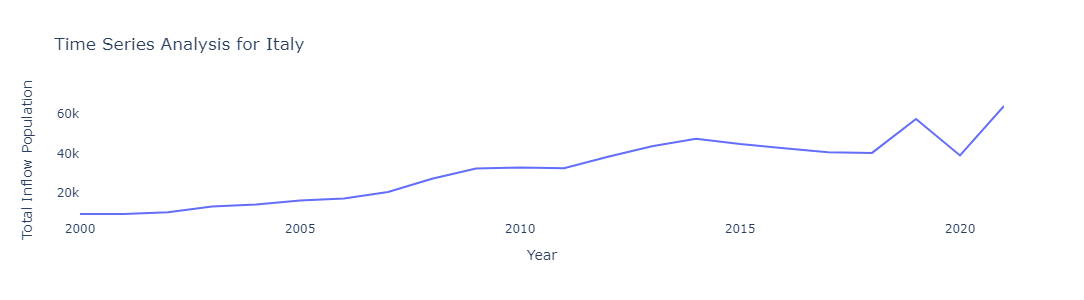

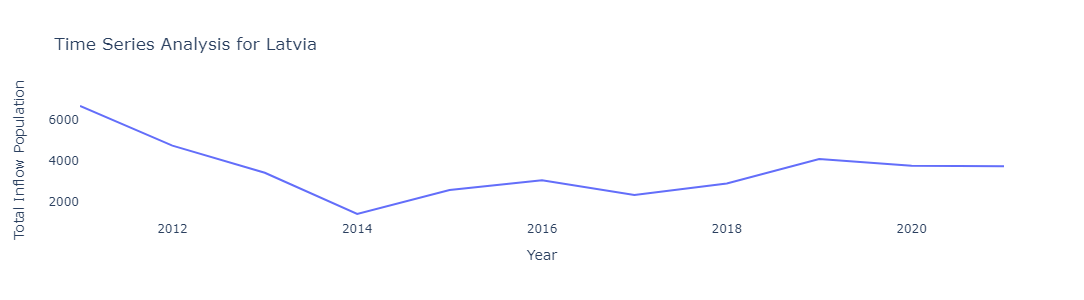

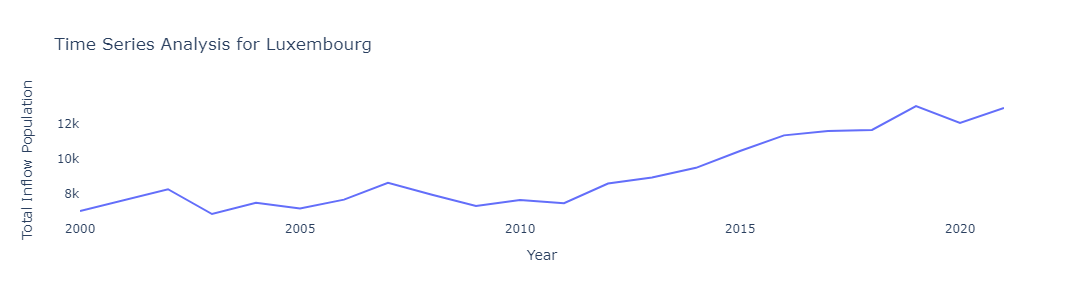

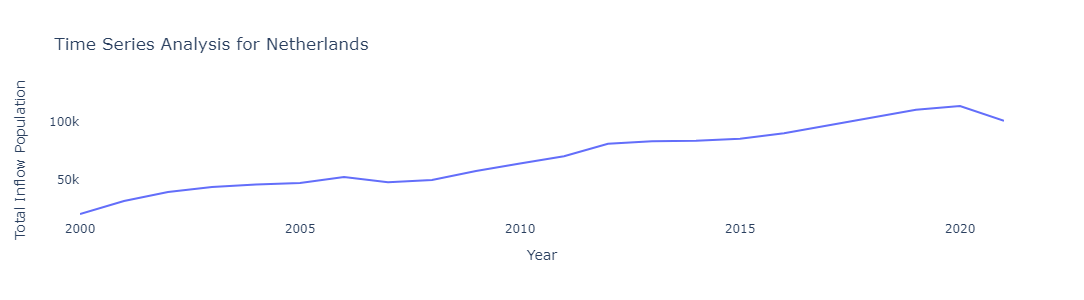

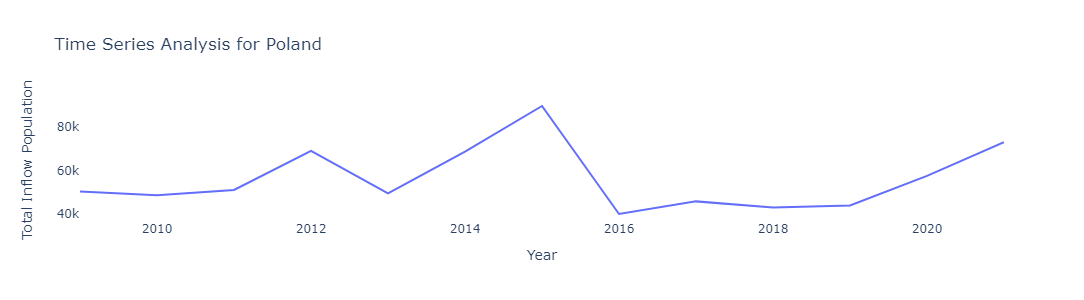

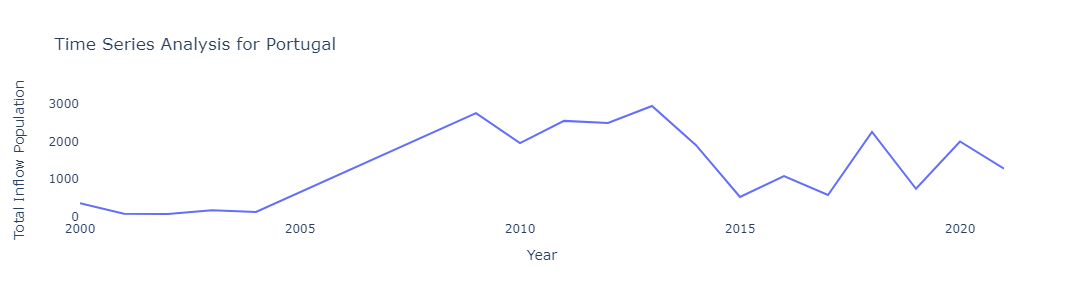

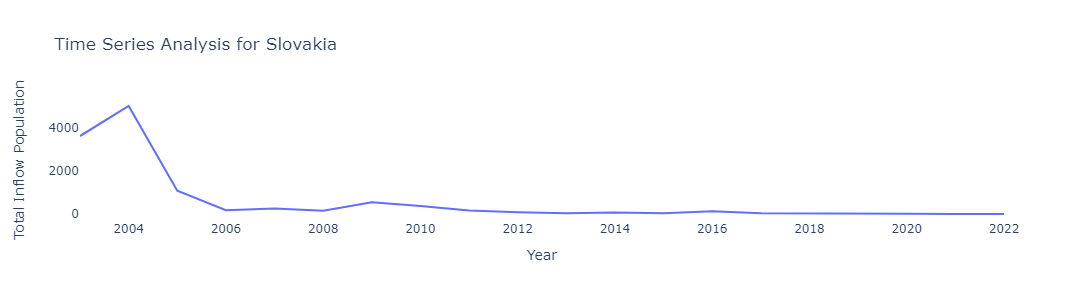

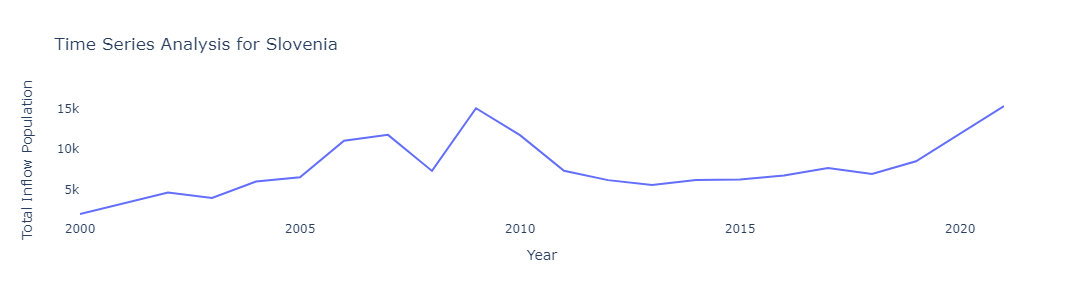

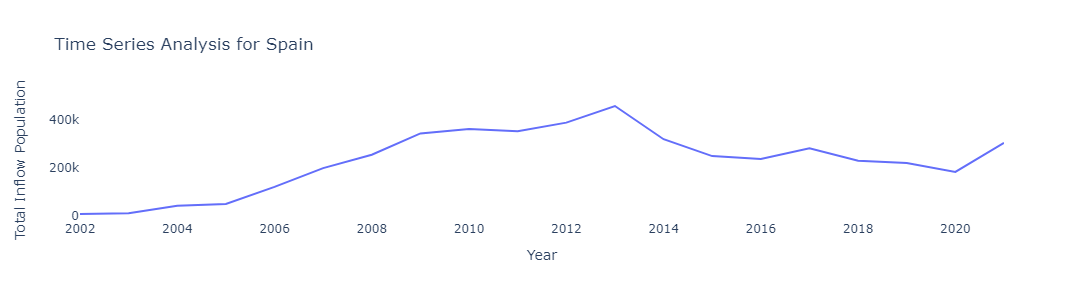

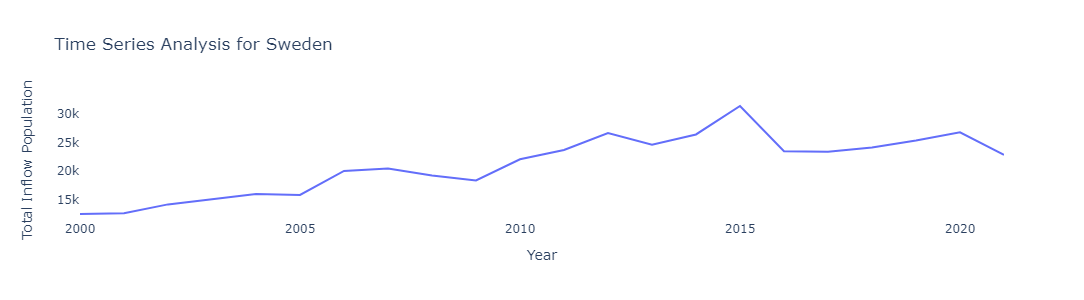

In [16]:
foreign_population_outflow_df.swifter.apply(create_time_series_plot, axis=1);

### Stock of Foreign Population

### Stock of Foreign Born Population

#### Analysis of Population Spikes/Dips

#### Population Spikes Context

Based on the analysis of population inflow acrss 2000-2022, it was determined that the years with the highest population spike/dip are: 

----------------------------------------------------------
**2020** - The main factor affecting immigration into the European Union (EU) in 2020 was the global COVID-19 pandemic. With widespread travel restrictions and border closures aimed at curbing the virus, international migration slowed significantly. Many individuals postponed or canceled plans to move to EU countries for work, study, or family reasons due to health concerns and travel limitations. Economic uncertainties resulting from the pandemic, such as job losses, also contributed to the decline in immigration. Overall, the pandemic led to a notable reduction in immigrant inflow to the EU compared to previous years.

**2015** - The major event in 2015 that affected immigrant inflow across the European Union (EU) was the European migrant crisis. This crisis was characterized by a significant influx of refugees and migrants, primarily from war-torn countries in the Middle East and North Africa, seeking asylum and better living conditions in EU member states. The crisis led to heightened tensions, debates over immigration policies, and the implementation of various measures by EU countries to manage the influx of migrants.

**2021** - In 2021, one significant event that increased immigrant inflow across the European Union (EU) was the Taliban's takeover of Afghanistan. This led to a surge in Afghan refugees seeking asylum in EU member states, particularly those involved in military operations in Afghanistan. The humanitarian crisis sparked by the Taliban's resurgence prompted discussions among EU countries regarding refugee resettlement and asylum policies, resulting in an increase in immigrant arrivals to the EU.

**2009** - In 2009, a major event that decreased immigrant inflow across the European Union (EU) was the global financial crisis. The economic downturn resulted in decreased job opportunities and heightened unemployment rates in many EU countries, leading to a decline in labor migration. Additionally, stricter immigration policies were implemented by some EU member states in response to the economic crisis, making it more challenging for immigrants to enter and find work in the EU.

### Part 3: Spatial Analysis of Immigration Across EU

The function defined below generates a heatmap centered around Europe. It uses geo spacial data from external libraries and our datasets to draw a heatmap showing which countries have the highest concentration of migrant population. 

In [17]:
# Load Geo spacial data from external library
world_geojson = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_geojson.to_file("data/world.geojson", driver='GeoJSON')


def generate_foreign_population_heat_map(data, field_name='Population'):
    # Defining coordinates for map center
    europe_center = [54.5260, 15.2551]

    # Initialize heat map
    europe_map = folium.Map(location=europe_center, zoom_start=4)

    # Create a Folium map with geo spacial data and loaded dataset
    folium.Choropleth(
        geo_data='data/world.geojson',
        data=data,
        # Using average values across all years (2000-2022)
        columns=[data.index, 'Average'],
        key_on='feature.properties.name',
        fill_color='viridis',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=field_name,

    ).add_to(europe_map)
    display(europe_map)

### Inflow Population

In [18]:
generate_foreign_population_heat_map(foreign_population_inflow_df, 'Inflow Population')


### Outflow Population

In [19]:
generate_foreign_population_heat_map(foreign_population_outflow_df, 'Outflow Population')

### Foreign Stock Population

In [20]:
generate_foreign_population_heat_map(stock_population_foreign_df, 'Foreign Stock Population')

### Foreign Born Stock Population

In [21]:
generate_foreign_population_heat_map(stock_population_foreign_born_df, 'Foreign Born Stock Population')

### Part 4: Forecasting of Future Population

Several forecasting methods were tried including ARIMA, RandomForestRegressor, VAR, and Linear Regression. However, due to limited amount of data, it was determined that a simple linear regression would be the best option. More advanced forecasting have been proven to be ineffective when predicting values for more than 1 year as there are little variation of the values across the subsequent years. 

#### Forecasting with Linear Regression

#### Defining Forecast Years

In [22]:
num_of_prediction_years = 5
last_year = 2022
forecast_years = [year for year in range(last_year+1, last_year + 1 + num_of_prediction_years)]

#### Define Forecasting Function

In [23]:
def forecast_population_growth(data, forecast_years):

    #Clean and reshape data for fitting
    cleaned_series = data[:-2].dropna()
    X = np.array(cleaned_series.index).reshape(-1, 1)
    y = np.array(cleaned_series.values).reshape(-1, 1)

    #Create linear regression model and fit data
    model = LinearRegression()
    model.fit(X, y)

    #Use model to predict data for forecast years
    forecast_data = model.predict(np.array(forecast_years).reshape(-1,1)).flatten()
    return pd.Series(forecast_data.astype(int), index = forecast_years)

### Inflow Population

In [24]:
foreign_population_inflow_df.apply(forecast_population_growth, args = ([forecast_years]), axis = 1)

2023     2024     2025     2026     2027
Country                                                 
Austria       162669   166485   170302   174119   177935
Belgium       136092   139004   141917   144830   147743
Czechia        52991    53584    54176    54769    55361
Denmark        54936    56497    58057    59618    61179
Estonia        12030    12732    13434    14136    14838
Finland        29705    30577    31450    32322    33194
France        278492   286040   293588   301136   308683
Germany      1553108  1600941  1648774  1696607  1744440
Greece         64987    66340    67693    69046    70399
Hungary        46716    48124    49532    50940    52348
Italy         279974   277900   275827   273753   271679
Latvia          6581     6824     7067     7310     7553
Luxembourg     26397    27098    27798    28499    29199
Netherlands   210048   216864   223680   230495   237311
Poland        164494   172021   179548   187075   194601
Portugal       86358    88453    90548    92643    94739
Slovakia        1874     1681     1489     1296     1103
Slovenia       18337    18304    18271    18238    18206
Spain         405464   400710   395955   391201   386446
Sweden        119851   122946   126042   129138   132234

### Outflow Population

In [25]:
foreign_population_outflow_df.apply(forecast_population_growth, args = ([forecast_years]), axis = 1)

2023    2024    2025     2026     2027
Country                                              
Austria       97825  100201  102577   104953   107329
Belgium       66479   67922   69365    70808    72251
Czechia       15588   15380   15173    14965    14758
Denmark       46860   48423   49986    51549    53112
Estonia        5719    6063    6407     6751     7095
Finland        7397    7624    7851     8077     8304
France        33831   33886   33941    33995    34050
Germany      937356  959716  982076  1004436  1026796
Greece        55395   56459   57523    58587    59651
Hungary       32287   33936   35586    37236    38885
Italy         60445   62769   65092    67416    69739
Latvia         2623    2497    2370     2243     2117
Luxembourg    12657   12939   13220    13501    13782
Netherlands  119825  123896  127968   132040   136111
Poland        57783   57989   58195    58401    58607
Portugal       2100    2167    2233     2299     2366
Slovakia       -828    -963   -1098    -1234    -1369
Slovenia      11037   11294   11551    11808    12064
Spain        368557  380528  392499   404470   416441
Sweden        29485   30153   30821    31490    32158